# 1. Exploratory Data Analysis

Data Source:

- Constante, Fabian; Silva, Fernando; Pereira, António (2019), “DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS”, Mendeley Data, V5, doi: 10.17632/8gx2fvg2k6.5

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1.1 Data Description

In [15]:
# load the source data
df_source = pd.read_csv('data/raw/DataCoSupplyChainDataset.csv', encoding='unicode_escape')

# convert the date columns to datetime
df_source['order date (DateOrders)']= pd.to_datetime(df_source['order date (DateOrders)'])

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head())


(180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [16]:
# show the data description
df_description = pd.read_csv('data/raw/DescriptionDataCoSupplyChain.csv')
df_description.DESCRIPTION = df_description.DESCRIPTION.str.replace(':', '')

df_description.style.set_properties(**{'text-align': 'left'})

,FIELDS,DESCRIPTION
0,Type,Type of transaction made
1,Days for shipping (real),Actual shipping days of the purchased product
2,Days for shipment (scheduled),Days of scheduled delivery of the purchased product
3,Benefit per order,Earnings per order placed
4,Sales per customer,Total sales per customer made per customer
5,Delivery Status,"Delivery status of orders Advance shipping , Late delivery , Shipping canceled , Shipping on time"
6,Late_delivery_risk,"Categorical variable that indicates if sending is late (1), it is not late (0)."
7,Category Id,Product category code
8,Category Name,Description of the product category
9,Customer City,City where the customer made the purchase


## 1.2 Correlation

References:
- [Plotting a diagonal correlation matrix](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

<AxesSubplot:>

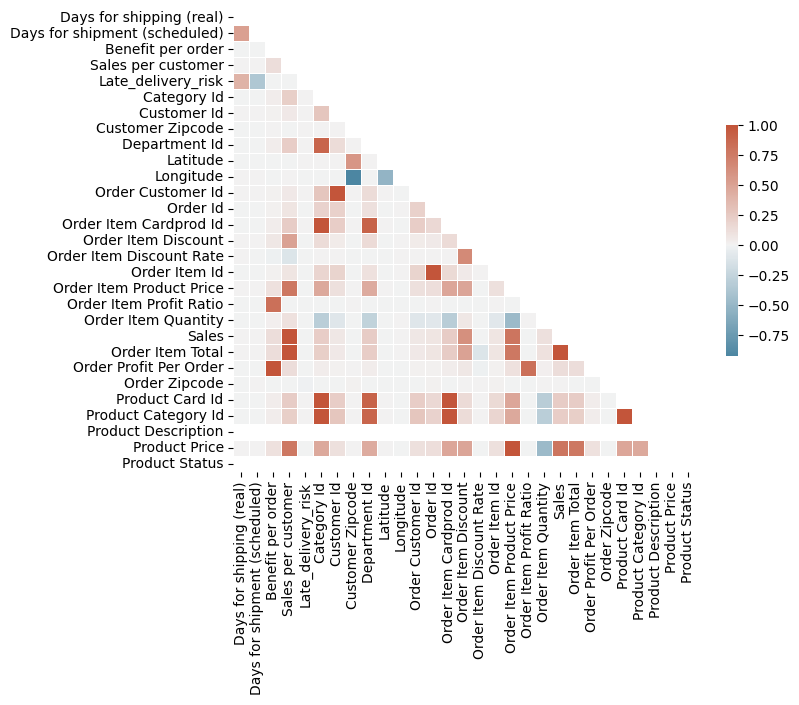

In [17]:
# Compute the correlation matrix
corr = df_source.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 1.3 Fraud

References:
- <div class="csl-entry">Constante-Nicolalde, F.-V., Guerra-Terán, P., &#38; Pérez-Medina, J.-L. (2020). <i>Fraud Prediction in Smart Supply Chains Using Machine Learning Techniques</i> (M. Botto-Tobar, M. Zambrano Vizuete, P. Torres-Carrión, S. Montes León, G. Pizarro Vásquez, &#38; B. Durakovic, Eds.; Vol. 1194, pp. 145–159). Springer International Publishing. https://doi.org/10.1007/978-3-030-42520-3_12</div>

### 1.3.1 Order Status

In [18]:
df_source['Order Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

### 1.3.2 Payment Type

In [19]:
df_source['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

### 1.3.3 Order Date

In [20]:
df_source['order date (DateOrders)'].describe()

/home/vscode/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  180519
unique                  65752
top       2016-12-14 12:29:00
freq                        5
first     2015-01-01 00:00:00
last      2018-01-31 23:38:00
Name: order date (DateOrders), dtype: object